In [1]:
!pip install tensorflow
!pip install opencv-python
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install numpy
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import cv2
from sklearn.model_selection import train_test_split
print ("done")



done


In [2]:


def crop_black_region(img, tol=7):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    return img[np.ix_(mask.any(1), mask.any(0))] if mask.any() else img

def enhance_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    cl = cv2.createCLAHE(clipLimit=2.0).apply(l)
    return cv2.cvtColor(cv2.merge((cl, a, b)), cv2.COLOR_LAB2RGB)

def resize_pad(img, target_size=224):
    h, w = img.shape[:2]
    scale = target_size / max(h, w)
    img = cv2.resize(img, (int(w * scale), int(h * scale)))
    pad_h, pad_w = target_size - img.shape[0], target_size - img.shape[1]
    top, bottom = pad_h // 2, pad_h - pad_h // 2
    left, right = pad_w // 2, pad_w - pad_w // 2
    return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def preprocess_image(path, size=224):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_black_region(img)
    img = enhance_contrast(img)
    img = resize_pad(img, size)
    return img.astype(np.float32) / 255.0

def load_images_from_folder(folder, label):
    images, labels = [], []
    for fname in os.listdir(folder):
        img_path = os.path.join(folder, fname)
        img = preprocess_image(img_path)
        images.append(img)
        labels.append(label)
    return images, labels


dr_path = r'C:\Users\onyem\OneDrive\Desktop\FinalYearProject\Data\train\DR'
no_dr_path = r'C:\Users\onyem\OneDrive\Desktop\FinalYearProject\Data\train\NO_DR'

X_dr, y_dr = load_images_from_folder(dr_path, 1)
X_no_dr, y_no_dr = load_images_from_folder(no_dr_path, 0)

X = np.array(X_dr + X_no_dr)
y = np.array(y_dr + y_no_dr)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("donee")

donee


Epoch 1/15
52/52 [==============================] - ETA: 0s - loss: 1.9585 - accuracy: 0.8645

C:\Users\onyem\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 176s 3s/step - loss: 1.9585 - accuracy: 0.8645 - val_loss: 21.7995 - val_accuracy: 0.5048
Epoch 2/15
52/52 [==============================] - 149s 3s/step - loss: 0.2487 - accuracy: 0.9187 - val_loss: 28.4673 - val_accuracy: 0.5048
Epoch 3/15
52/52 [==============================] - 142s 3s/step - loss: 0.1880 - accuracy: 0.9114 - val_loss: 21.9114 - val_accuracy: 0.5048
Epoch 4/15
52/52 [==============================] - 147s 3s/step - loss: 0.1638 - accuracy: 0.9398 - val_loss: 7.2372 - val_accuracy: 0.5048
Epoch 5/15
52/52 [==============================] - 134s 3s/step - loss: 0.1488 - accuracy: 0.9416 - val_loss: 4.4421 - val_accuracy: 0.5096
Epoch 6/15
52/52 [==============================] - 133s 3s/step - loss: 0.1552 - accuracy: 0.9458 - val_loss: 1.2900 - val_accuracy: 0.7139
Epoch 7/15
52/52 [==============================] - 130s 3s/step - loss: 0.1263 - accuracy: 0.9494 - val_loss: 0.8550 - val_accuracy: 0.6442
Epoch 8/15
52/52 [===

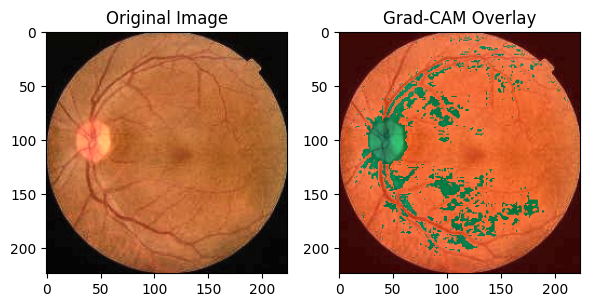

In [3]:

def build_custom_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', name='conv2'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', name='conv3'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = build_custom_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = 'Retinopathy_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, tf.keras.utils.to_categorical(y_train, 2),
                    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, 2)),
                    epochs=15, batch_size=32,
                    callbacks=[checkpoint, earlystop], verbose=1)

model = load_model(checkpoint_path)
_ = model.predict(np.zeros((1, 224, 224, 3)))

y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", cm)


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

sample_idx = 0
sample_img = np.expand_dims(X_val[sample_idx], axis=0)
heatmap = make_gradcam_heatmap(sample_img, model, last_conv_layer_name='conv3')
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = heatmap_color * 0.4 + (X_val[sample_idx] * 255)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(X_val[sample_idx])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(np.uint8(overlay))
plt.title('Grad-CAM Overlay')
plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 212ms/step
Prediction: DR (88.20% confidence)


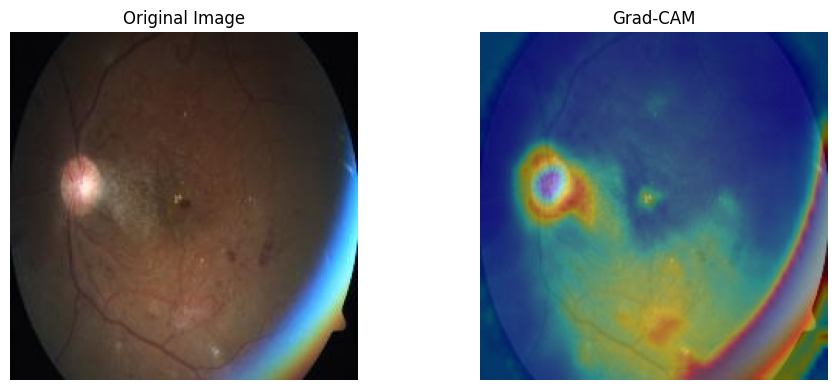

In [6]:


model_path = r'C:\Users\onyem\OneDrive\Desktop\FinalYearProject\Retinopathy_model.h5'
image_path = r'C:\Users\onyem\OneDrive\Desktop\FinalYearProject\Data\test\DR\0ada12c0e78f_png.rf.3e8e491a2cacb9af201e2f89f3afca61.jpg'
class_names = ['No_DR', 'DR']
img_size = (224, 224)


model = tf.keras.models.load_model(model_path)


def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return np.expand_dims(img, axis=0), img

img_array, original_img = preprocess_image(image_path)


prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]

print(f"Prediction: {class_names[predicted_class]} ({confidence*100:.2f}% confidence)")


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break


heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


def display_gradcam(heatmap, original_img, alpha=0.4):

    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


    original_uint8 = np.uint8(original_img * 255)


    overlay = cv2.addWeighted(original_uint8, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

gradcam_output = display_gradcam(heatmap, original_img)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(gradcam_output)
plt.axis("off")
plt.tight_layout()
plt.show()


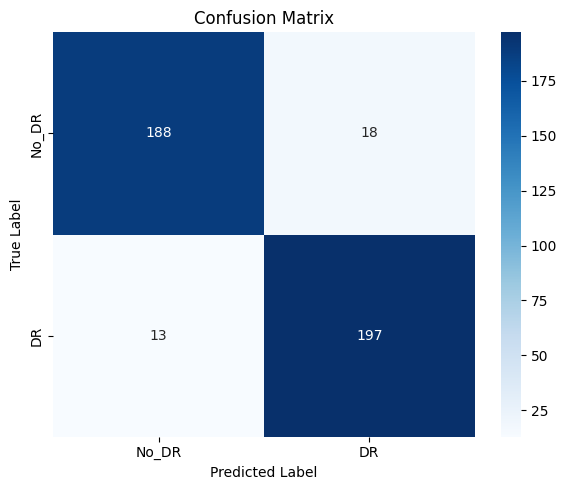

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix values
cm = [[188, 18],
      [13, 197]]

# Labels for the classes
labels = ['No_DR', 'DR']

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()